# Assignment based on Tutorial II: Fully connected NNs
<p>
AICP, 2024<br>
Prepared by Mykhailo Vladymyrov.
</p>
This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Baseline Model (2-layer NN) 1500 neurons in first hidden layer with ReLU activation, 10 neurons in output layer with softmax activation, learning rate 0.001, 10 epochs, batch size 64.

## 1. Load necessary libraries



In [32]:
import os
import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader 


## 2. Structure of a neural network

In [2]:
#Class Definition and Initialization
class MyModel(nn.Module):
    def __init__(self, n_input, n_hiddens, n_output): 
        super(MyModel, self).__init__()

        # Creating the Hidden Layers      
        self.ls = []#list to store the hidden layers
        n_prev = n_input
        for i, n_out in enumerate(n_hiddens):
          l = nn.Linear(n_prev, n_out)  #Create a linear layer from n_prev to n_out neurons.
          n_prev = n_out # Update n_prev to the current layer's output size
          self.add_module(f'lin_{i}_{n_out}', l) # registers the layer with the model
          self.ls.append(l) # Add the layer to the list of layers

        #Creating the Output Layer
        self.lout = nn.Linear(n_prev, n_output) # final layer to match the output classes n_outtput in dataset
  
#Forward Pass Definition
    def forward(self, x):
        # Flatten the input image to 1D before passing to linear layers
        x = torch.flatten(x, start_dim=1)  # Flatten to (batch_size, 784), pushed it from loading data to here to keep images in their original 2D form (28x28) throughout the data loading process giving more flexibility in data augmentation and preprocessing.
        
        h = x # The initial hidden state is the input x
        for li in self.ls:  
          h = li(h) 
          h = torch.relu(h) # each hidden layer is followed by ReLU activation

        # Output Layer and Softmax Activation
        logits = self.lout(h) # Output layer (logits)
        probs = F.softmax(logits, dim=1) # apply softmax activation to logits to convert them into class probabilities
        pred = torch.argmax(probs, dim=1) # gets the predicted class

        return logits, probs, pred
        

## 3. Load the data

First we will load the data: 60000 training images and 10000 images for validation with some included data transformations.Each image is a 28x28 pixels. For this model we will interpret it as a 1D array of 784 elements.Note: The images are originally 28x28 pixels. Since a neural network expects a flat array of features (a 1D vector), each 28x28 image needs to be transformed into a 1D array of 784 elements (since 28×28=784).

In [3]:
# Define the transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor(), # Converts the PIL Image to a tensor. This also converts the pixel values from 0-255 to 0-1.
                                transforms.Normalize((0.5,), (0.5,))]) # Normalizes the tensor with mean 0 and standard deviation 1.
                                

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Print shapes of the datasets
print('Train dataset shape:', len(trainset), 'total images and labels')
print('Test dataset shape:', len(testset), 'total images and labels')
#The len() function returns the total number of items in the dataset. For FashionMNIST, len(trainset) will return 60,000, and len(testset) will return 10,000.

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


In [4]:
#Looping Over the Dataset
for el in trainset:
  x, y = el
  print(x.shape, y)
  break

torch.Size([1, 28, 28]) 9


In [5]:
for el in trainloader:
  x, y = el 
  print(x.shape, y.shape) 
  break

torch.Size([64, 1, 28, 28]) torch.Size([64])


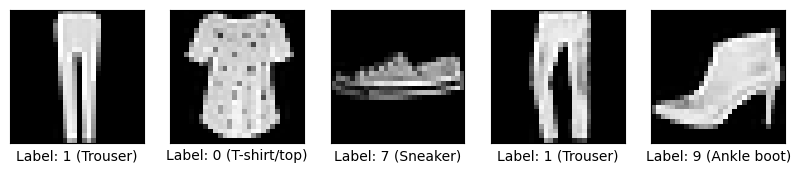

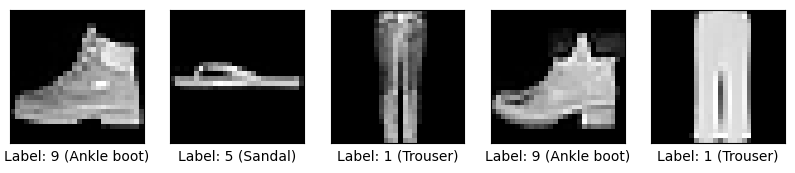

In [6]:
class_names = trainset.classes
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # Reshape the flattened images back to 28x28 for display
        plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        lbl = labels[i].item()
        plt.xlabel(f'Label: {lbl} ({class_names[lbl]})')
    plt.show()

# Function to get random images and labels from a dataset
def get_random_images(loader, num_images=5):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    indices = list(range(len(images)))
    random_indices = random.sample(indices, num_images)
    random_images = images[random_indices]
    random_labels = labels[random_indices]
    return random_images, random_labels

# Get random images and labels from the training set
random_images, random_labels = get_random_images(trainloader, num_images=5) 
# Show images
show_images(random_images, random_labels, num_images=5)

# and for the test set:
random_images, random_labels = get_random_images(testloader, num_images=5)
show_images(random_images, random_labels, num_images=5)



Check out the dimensions of the data

In [7]:
# Inspect the dimensions of the sample elements
print("Shape of the images:", random_images.shape)#Tells you the dimensions of the batch of images (e.g., how many images and how they are represented).
print("Shape of the labels:", random_labels.shape) #Tells you the dimensions of the batch of labels (e.g., how many labels correspond to the images).
print(random_labels)#Displays the actual label values for the batch, allowing you to see what classes each image in the batch belongs to.

Shape of the images: torch.Size([5, 1, 28, 28])
Shape of the labels: torch.Size([5])
tensor([9, 5, 1, 9, 1])


## 6. Bulding a neural network

Number of inputs for neurons will be given by input data, i.e. image dims (flattened), size. Output - by number of classes, 10 in our case.

In [8]:
model = MyModel(n_input=784, n_hiddens=[1500], n_output=10)  

In [9]:
# Function to get the number of parameters
def get_npars(model):
    """
    Returns the total number of trainable parameters in the given PyTorch model.
    """
    n = np.sum([np.prod(list(p.shape)) for p in model.parameters()])
    return int(n)

# Get and print the number of parameters in the model
num_parameters = get_npars(model)
print(f'The model has {num_parameters} trainable parameters.')


The model has 1192510 trainable parameters.


In [10]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam) without regularization
optimizer = optim.Adam(model.parameters(), lr=0.001)  # No weight decay for regularization


Defining a training function:

In [11]:
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  # reset gradients
        output, _, _ = model(images) # passes images through model to get raw outputs (logits), probabilities and predicted labels
        loss = criterion(output, labels) # computes loss between predicted and true labels using cross entropy loss (criterion)
        loss.backward()  # computes gradients of the loss with respect to the model's parameters using backpropagation   
        optimizer.step()  # updates model parameters using the computed gradients and the optimizer's learning rate
        running_loss += loss.item() # adds the current batch's loss to the total loss for this epoch
    return running_loss / len(trainloader) # computes average loss over all batches in the epoch to track training progress


Defining a testing function:

In [12]:
def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    n_correct = 0
    n_samples = 0  # To keep track of the total number of samples

    with torch.no_grad(): # Disables gradient computation for testing
        for images, labels in testloader:
            output, prob, pred = model(images)
            loss = criterion(output, labels) # calculate the loss
            running_loss += loss.item()

            correct = torch.sum(pred == labels) # number of correct predictions in the batch
            n_correct += correct.item()  # Accumulate the correct predictions
            n_samples += labels.size(0)  # Accumulate the total number of samples

    accuracy = n_correct / n_samples  # Compute overall accuracy
    return running_loss / len(testloader), accuracy

In [13]:
testloader.batch_size

64

Training the model

In [16]:
import time

# Lists to store losses and accuracy for Baseline model
train_losses_baseline = []
test_losses_baseline = []
test_accuracies_baseline = []  
time_per_epoch_baseline = []

num_epochs = 10 # Number of epochs for training

for epoch in range(num_epochs):
    start_time = time.time()  # Startzeit für die Epoche
    train_loss = train(model, trainloader, criterion, optimizer)
    test_loss, test_accuracy = test(model, testloader, criterion)  # Assuming test returns loss and accuracy

   # Store losses for Baseline model
    train_losses_baseline.append(train_loss)
    test_losses_baseline.append(test_loss)

     # Store accuracy for TestB model
    test_accuracies_baseline.append(test_accuracy)

    end_time = time.time()  # Endzeit der Epoche
    epoch_time = end_time - start_time  # Berechne die Zeit für diese Epoche
    time_per_epoch_baseline.append(epoch_time)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.1392, Test Loss: 0.4061, Test Accuracy: 0.8909
Epoch 2/10, Train Loss: 0.1351, Test Loss: 0.4091, Test Accuracy: 0.8907
Epoch 3/10, Train Loss: 0.1316, Test Loss: 0.4131, Test Accuracy: 0.8897
Epoch 4/10, Train Loss: 0.1254, Test Loss: 0.4035, Test Accuracy: 0.8921
Epoch 5/10, Train Loss: 0.1217, Test Loss: 0.4637, Test Accuracy: 0.8839
Epoch 6/10, Train Loss: 0.1224, Test Loss: 0.4533, Test Accuracy: 0.8881
Epoch 7/10, Train Loss: 0.1139, Test Loss: 0.4326, Test Accuracy: 0.8921
Epoch 8/10, Train Loss: 0.1122, Test Loss: 0.4623, Test Accuracy: 0.8833
Epoch 9/10, Train Loss: 0.1074, Test Loss: 0.4945, Test Accuracy: 0.8834
Epoch 10/10, Train Loss: 0.1053, Test Loss: 0.4587, Test Accuracy: 0.8920


Visualize the loss curves

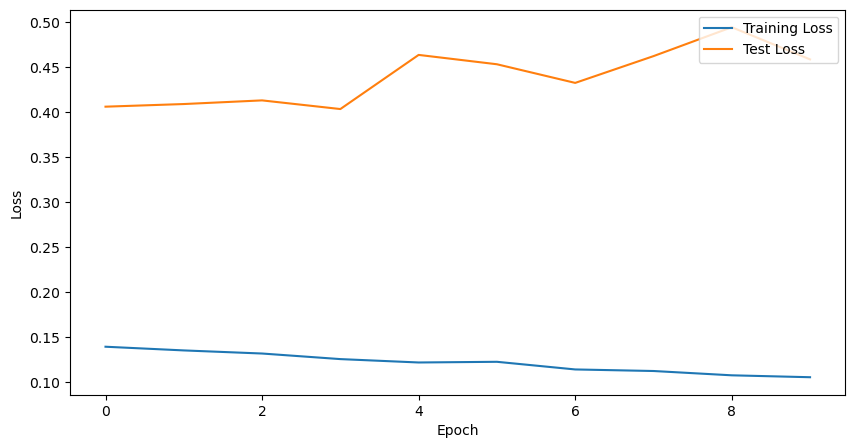

In [17]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses_baseline, label='Training Loss')
ax.plot(range(num_epochs), test_losses_baseline, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()

In [18]:
for p in model.parameters():
  print(np.prod(list(p.shape)))

1176000
1500
15000
10


In [19]:
get_npars(model)

1192510

In [20]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, _, _ = model(images)
            pred = output.argmax(dim=1)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy

# Get predictions, labels, and images
predictions, labels, images_list = get_predictions(model, testloader)
correct = [pred == label for pred, label in zip(predictions, labels)]

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.892


Aggregate a correct and incorrect example and visualize:

First incorrect digit is at index: 15


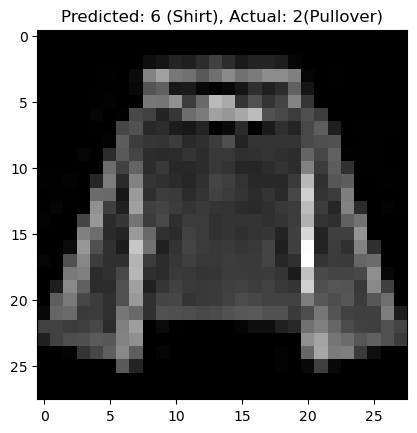

First correct digit is at index: 0


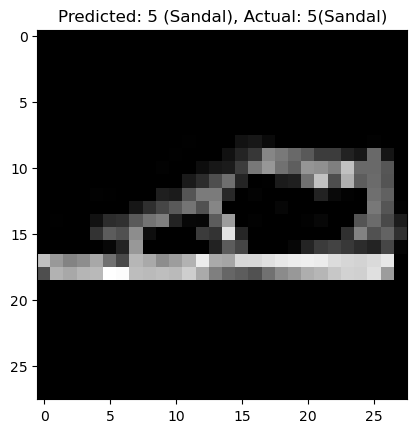

In [21]:

# Find the index of the first incorrect and correct prediction
wrong_idx = next((i for i, correct in enumerate(correct) if not correct), None)
correct_idx = next((i for i, correct in enumerate(correct) if correct), None)

# Function to display an image
def display_image(image, title):
    plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.show()

# Display the first incorrect sample (if any incorrect are found)
if wrong_idx is not None:
    print(f"First incorrect digit is at index: {wrong_idx}")
    pred = predictions[wrong_idx]
    lbl  = labels[wrong_idx]
    display_image(images_list[wrong_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No incorrect predictions found")

# Display the first correct sample (if any correct are found)
if correct_idx is not None:
    print(f"First correct digit is at index: {correct_idx}")
    pred = predictions[correct_idx]
    lbl  = labels[correct_idx]
    display_image(images_list[correct_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No correct predictions found")

## 7. Visualizing the Parameters

The model's layers are stored in model.ls and model.lout - for the output layer.
In out case this is the only layer.

The learned model parameters W1 are a matrix of weights that show importance of each input pixel (784) for each of the 10 outputs.

torch.Size([10, 1500]) torch.Size([10])


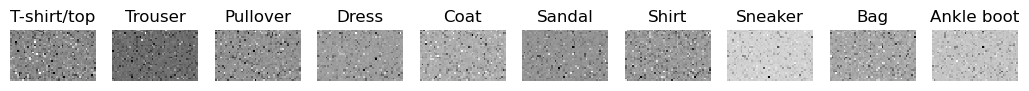

In [22]:
layer = model.lout #The code is accessing the output layer
n_features = layer.out_features # number of output features (classes) should be 10 for 10 classes.
#n_features is the number of output classes (10), and 1500 is the number of neurons in the hidden layer
#For example, if w1.shape is (10, 1500), it means each output neuron (class) connects to all 1500 neurons in the hidden layer.
w1, b1 = layer.weight.data, layer.bias.data #extract weights and biases from the output layer.
print(w1.shape, b1.shape) ## Expecting w1 to be [n_features, 1500]

#Choose a reshape that fits the number of neurons in the hidden layer (1500),  # Adjust the view dimensions as per your layer's configuration
# Let's reshape each weight vector to a 2D grid that fits: for example, (30, 50)
w1_reshaped = w1.view(n_features, 30, 50) #Adjust the view dimensions as per your layer's configuration

# Plotting the weights
_, axs = plt.subplots(1, n_features, figsize=(13, 5))

for i in range(10): # Loop over the number of output features (classes)
    axs[i].imshow(w1_reshaped[i].numpy(), cmap='gray', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')
    axs[i].set_title(f'{trainset.classes[i]}')
plt.show()

Here we classify images into 10 classes. But think of it: does the network know, or need to know that those were images? For the network each image is just a 784 values. And it finds that there is a patten.

Same way one can feed any other bunch of numbers, and the network will try it's best to fugure out a relation pattern between those.






In [23]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, probs, pred = model(images)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy



In [24]:
predictions, labels, images_list = get_predictions(model, testloader)  # TEST

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.892


In [25]:
import datetime

# Get the current date and time for unique naming
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the filename using only the test name (will overwrite with each run)
test_name = "baseline"  # Replace with your test name
model_filename = f'{test_name}_trained_model.pth'

# Save the model and optimizer state dicts
save_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_loss': train_losses_baseline,
    'test_loss': test_losses_baseline,
    'time_per_epoch': time_per_epoch_baseline
    
}

torch.save(save_dict, model_filename)  # Add this line to actually save the dictionary
print(f'Trained model saved as {model_filename}')

Trained model saved as baseline_trained_model.pth


In [26]:
# Code for Storing Results in JSON Files
import json

# Store the results (losses and accuracy) in a dictionary
results = {
    'train_losses': train_losses_baseline,  
    'test_losses': test_losses_baseline,    
    'test_accuracies': test_accuracies_baseline, 
    'final_accuracy': accuracy,  # Store the final accuracy as a separate key
    'time_per_epoch': time_per_epoch_baseline
}

# Save results to a JSON file, overwrite each time
json_filename = f'{test_name}_results.json'  # No timestamp to allow overwriting
with open(json_filename, 'w') as f:
    json.dump(results, f)
print(f'Results saved in {json_filename}')


Results saved in baseline_results.json
